In [1]:
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt 
%matplotlib inline
from scipy import sparse
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs
from scipy.optimize import curve_fit

#-------------------------------------------------------------------------------
#// Define Pauli matrix
#-------------------------------------------------------------------------------
pauli_x = np.array([[0,1],[1,0]]).astype(float)
pauli_z = np.array([[1,0],[0,-1]]).astype(float)

#-------------------------------------------------------------------------------
#// Define Hamiltonian matrix (spin basis)
#-------------------------------------------------------------------------------
def Hx(L):
    """
    Construct \sum_{j}\sigma^x_{j}
    Parameter : ------------------------------------
        L: scalar. lattice size.
    Return: ----------------------------------------   
        out: 2d-array. The shape is [2**L, 2**L]
    """
    Hx_list = [np.eye(2) for i in range(L)]
    Hx_list[0] = pauli_x
    Hx = 0
    for i in range(L):
        Hx += reduce(lambda a,b: np.kron(a,b), Hx_list)
        Hx_list = np.roll(Hx_list, 1, axis=0)
    return Hx


def Hxx(L):
    """
    Construct \sum_{j}\sigma^x_{j}\sigma^x_{j+1} in PBC
    Parameter : ------------------------------------
        L: scalar. lattice size.
    Return: ----------------------------------------   
        out: 2d-array. The shape is [2**L, 2**L]
    """
    Hxx_list = [np.eye(2) for i in range(L)]
    Hxx_list[0] = pauli_x
    Hxx_list[1] = pauli_x
    Hxx = 0
    for i in range(L):
        Hxx += reduce(lambda a,b: np.kron(a,b), Hxx_list)
        Hxx_list = np.roll(Hxx_list, 1, axis=0)
    return Hxx


def Hz(L):
    """
    Construct \sum_{j}\sigma^z_{j}
    Parameter : ------------------------------------
        L: scalar. lattice size.
    Return: ----------------------------------------   
        out: 2d-array. The shape is [2**L, 2**L]
    """
    Hz_list = [np.eye(2) for i in range(L)]
    Hz_list[0] = pauli_z
    Hz = 0
    for i in range(L):
        Hz += reduce(lambda a,b: np.kron(a,b), Hz_list)
        Hz_list = np.roll(Hz_list, 1, axis=0)
    return Hz

def Hzz(L):
    """
    Construct \sum_{j}\sigma^z_{j}\sigma^z_{j+1} in PBC
    Parameter : ------------------------------------
        L: scalar. lattice size.
    Return: ----------------------------------------   
        out: 2d-array. The shape is [2**L, 2**L]
    """
    Hzz_list = [np.eye(2) for i in range(L)]
    Hzz_list[0] = pauli_z
    Hzz_list[1] = pauli_z
    Hzz = 0
    for i in range(L):
        Hzz += reduce(lambda a,b: np.kron(a,b), Hzz_list)
        Hzz_list = np.roll(Hzz_list, 1, axis=0)
    return Hzz

#----------------------------------------------------------------------
#// Define sparse Pauli matrix
#----------------------------------------------------------------------
pauli_x_sparse = sparse.csr_matrix(pauli_x)
pauli_z_sparse = sparse.csr_matrix(pauli_z)

#----------------------------------------------------------------------
#// Define sparse Hamiltonian matrix
#----------------------------------------------------------------------
def Hx_sparse(L):
    """
    Construct \sum_{i}\sigma^x_{i}
    Parameter : ------------------------------------
        L: scalar. lattice size.
    Return: ----------------------------------------   
        out: 2d-array. The shape is [2**L, 2**L]
    """
    op_list = [sparse.identity(2) for i in range(L)]
    op_list[0] = pauli_x_sparse
    Hx = 0
    for i in range(L):
        Hx += reduce(lambda a,b: sparse.kron(a,b,format='csr'), op_list)
        op_list = np.roll(op_list, 1, axis=0)
    return Hx


def Hz_sparse(L):
    """
    Construct \sum_{i}\sigma^z_{i}
    Parameter : ------------------------------------
        L: scalar. lattice size.
    Return: ----------------------------------------   7
        out: 2d-array. The shape is [2**L, 2**L]
    """
    op_list = [sparse.identity(2) for i in range(L)]
    op_list[0] = pauli_z_sparse
    Hz = 0
    for i in range(L):
        Hz += reduce(lambda a,b: sparse.kron(a,b,format='csr'), op_list)
        op_list = np.roll(op_list, 1, axis=0)
    return Hz


def Hxx_sparse(L):
    """
    Construct \sum_{i}\sigma^x_{i}\sigma^x_{i+1} in PBC
    Parameter : ------------------------------------
        L: scalar. lattice size.
    Return: ----------------------------------------   
        out: 2d-array. The shape is [2**L, 2**L]
    """
    op_list = [sparse.identity(2) for i in range(L)]
    op_list[0] = pauli_x_sparse
    op_list[1] = pauli_x_sparse
    Hxx = 0
    for i in range(L):
        Hxx += reduce(lambda a,b: sparse.kron(a,b,format='csr'), op_list)
        op_list = np.roll(op_list, 1, axis=0)
    return Hxx


def Hzz_sparse(L):
    """
    Construct \sum_{i}\sigma^z_{i}\sigma^z_{i+1} in PBC
    Parameter : ------------------------------------
        L: scalar. lattice size.
    Return: ----------------------------------------   
        out: 2d-array. The shape is [2**L, 2**L]
    """
    op_list = [sparse.identity(2) for i in range(L)]
    op_list[0] = pauli_z_sparse
    op_list[1] = pauli_z_sparse
    Hzz = 0
    for i in range(L):
        Hzz += reduce(lambda a,b: sparse.kron(a,b,format='csr'), op_list)
        op_list = np.roll(op_list, 1, axis=0)
    return Hzz

#----------------------------------------------------------------------
#// Others
#----------------------------------------------------------------------
def find_crossing(x, y1, y2):
    """
    find the crossing point of two lines.
    Parameter : -------------------------
        x: 1D-array
        y1: 1D-array
        y2: 1D-array      
    Return: -----------------------------   
        out: scalar. Return False if no crossing.   
    """
    i = False
    for j in range(len(x)-1):
        if (y1[j]-y2[j])*(y1[j+1]-y2[j+1])<0:
            i = j
            break
            
    if i == False:
        return False
    frac_up = (y1[i+1]-y2[i+1])*x[i] - (y1[i]-y2[i])*x[i+1]
    frac_dw = (y1[i+1]-y2[i+1]) - (y1[i]-y2[i])
    return  frac_up/frac_dw

# Transverse-field Ising model

$$
H = -J\sum_{i}\sigma^x_{i}\sigma^x_{i+1} -h\sum_{i}\sigma^z_{i}
$$

The transverse-field Ising model is a quantum version of the classical Ising model. It has a second-order phase transition at $h/J=1$, where the ferromagnetic phase for $h<J$ and the paramagnetic phase for $h>J$.

In [8]:
for i in range(100):
    H = -1*Hzz_sparse(18)-0.1*Hx_sparse(18)

v[:,0] [ 6.87355185e-01 -7.58310512e-20 -1.07261305e-18 -1.76889627e-17
 -2.82506069e-18 -1.26503770e-16  4.24342831e-17 -1.34645493e-17
  2.33119125e-17 -1.58264618e-17 -1.12729282e-16 -2.08977197e-17
 -1.25182986e-17  1.49860704e-17 -1.16297506e-17 -7.26321450e-01]
v[:,0] [0.70621299 0.01772136 0.01772136 0.0017677  0.01772136 0.00088496
 0.0017677  0.01772136 0.01772136 0.0017677  0.00088496 0.01772136
 0.0017677  0.01772136 0.01772136 0.70621299]
v[:,0] [0.70341426 0.03569273 0.03569273 0.00706683 0.03569273 0.00355125
 0.00706683 0.03569273 0.03569273 0.00706683 0.00355125 0.03569273
 0.00706683 0.03569273 0.03569273 0.70341426]
v[:,0] [0.69837278 0.05410154 0.05410154 0.01586183 0.05410154 0.00802201
 0.01586183 0.05410154 0.05410154 0.01586183 0.00802201 0.05410154
 0.01586183 0.05410154 0.05410154 0.69837278]
v[:,0] [0.69058446 0.07300468 0.07300468 0.02801715 0.07300468 0.01429862
 0.02801715 0.07300468 0.07300468 0.02801715 0.01429862 0.07300468
 0.02801715 0.07300468 0.07300

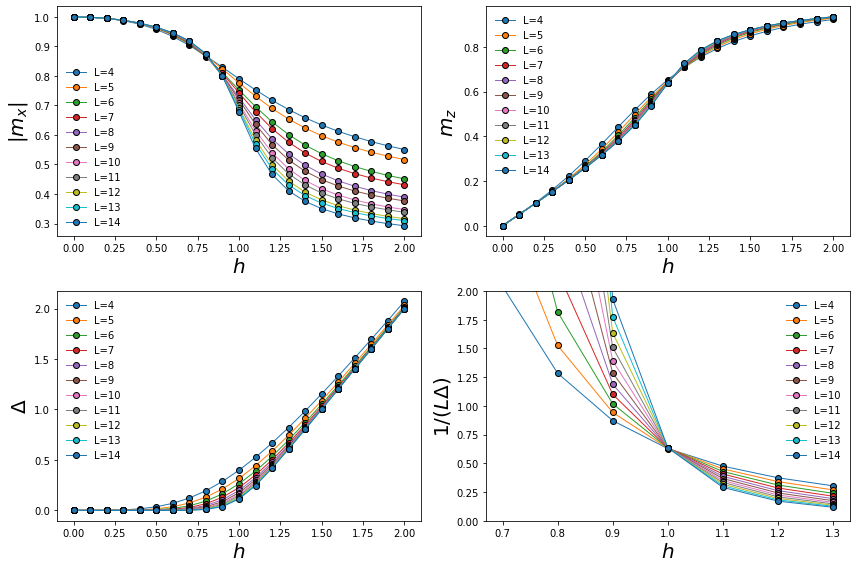

In [2]:
%%time
# -----------------------------------------------------
#// parameter
# -----------------------------------------------------
Llist = np.arange(4,15)
J = 1
hlist = np.linspace(0,2,21)

# -----------------------------------------------------
#// Calculate
# -----------------------------------------------------
Gaplist = np.zeros([Llist.size,hlist.size])
Mxlist = np.zeros([Llist.size,hlist.size])
Mzlist = np.zeros([Llist.size,hlist.size])
for i,L in enumerate(Llist):
    for j,h in enumerate(hlist):
        #// doing rotation (z->x and x->-z) in order to compute |mx|
        H = -J*Hzz_sparse(L)-h*Hx_sparse(L)
        w,v = eigsh(H, k=2, which='SA')
        #// collect result
        Gaplist[i][j] = w[1]-w[0]
        Mzlist[i][j] = v[:,0]@Hx_sparse(L)@v[:,0]/L
        Mxlist[i][j] = v[:,0]@abs(Hz_sparse(L))@v[:,0]/L
        print("v[:,0]",v[:,0])
# -----------------------------------------------------
#// Plot
# -----------------------------------------------------
plt.figure(figsize=(12,8))
#//----------------------------------
plt.subplot(2,2,1)
for i,L in enumerate(Llist):
    plt.plot(hlist, Mxlist[i], linewidth=1, marker='o', 
            markeredgecolor='k', label='L=%d'%L)
plt.xlabel('$h$', fontsize=20)
plt.ylabel('$|m_x|$', fontsize=20)
plt.legend(framealpha=1, edgecolor='w')
#//----------------------------------
plt.subplot(2,2,2)
for i,L in enumerate(Llist):
    plt.plot(hlist, Mzlist[i], linewidth=1, marker='o', 
            markeredgecolor='k', label='L=%d'%L)
plt.xlabel('$h$', fontsize=20)
plt.ylabel('$m_z$', fontsize=20)
plt.legend(framealpha=1, edgecolor='w')
#//----------------------------------
plt.subplot(2,2,3)
for i,L in enumerate(Llist):
    plt.plot(hlist, Gaplist[i], linewidth=1, marker='o', 
            markeredgecolor='k', label='L=%d'%L)
plt.xlabel('$h$', fontsize=20)
plt.ylabel('$\Delta$', fontsize=20)
plt.legend(framealpha=1, edgecolor='w')
#//----------------------------------
plt.subplot(2,2,4)
idx = (hlist<1.31) == (hlist>0.69) #//avoid to divide by zero
for i,L in enumerate(Llist):
    plt.plot(hlist[idx], 1/Gaplist[i][idx]/L, linewidth=1, marker='o', 
            markeredgecolor='k', label='L=%d'%L)
plt.xlabel('$h$', fontsize=20)
plt.ylabel('$1/(L\Delta)$', fontsize=20)
plt.ylim(0,2)
plt.legend(framealpha=1, edgecolor='w')
plt.tight_layout()

## Determine critical point $h_c$

According to finite-size scaling theory, the pseudo-critical point $h_c(L)$ at lattice size L satisfies

$$
\frac{L\Delta_{L}}{(L-1)\Delta_{L-1}}=1
$$

The critical point $h_c(\infty)$ can be determined by fitting the following equation:

$$
h_c(L)=h_c(\infty)-Be^{-b}
$$

CPU times: user 1min 16s, sys: 549 ms, total: 1min 16s
Wall time: 25.4 s


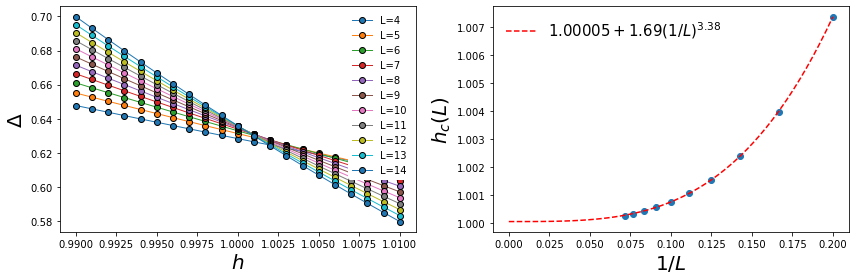

In [3]:
%%time
# -----------------------------------------------------
#// parameter
# -----------------------------------------------------
Llist = np.arange(4,15)
J = 1
hlist = np.linspace(0.990,1.01,21)

# -----------------------------------------------------
#// Calculate
# -----------------------------------------------------
Gaplist = np.zeros([Llist.size,hlist.size])
for i,L in enumerate(Llist):
    for j,h in enumerate(hlist):
        H = -J*Hxx_sparse(L)-h*Hz_sparse(L)
        E = eigsh(H,k=2,which='SA')[0]
        Gaplist[i][j] = E[1]-E[0]

# -----------------------------------------------------
#// Curve fitting
# -----------------------------------------------------
def func(x, a, b, c):
    return a+b*x**c
hclist = np.zeros(Llist.size-1)
for i in range(Llist.size-1):
    y1, y2 = 1/Gaplist[i]/Llist[i], 1/Gaplist[i+1]/Llist[i+1]
    hc = find_crossing(hlist, y1, y2)
    hclist[i] = hc
popt, pcov = curve_fit(func, 1/Llist[1:], hclist)

# -----------------------------------------------------
#// Plot
# -----------------------------------------------------
plt.figure(figsize=(12,4))
#//----------------------------------
plt.subplot(1,2,1)
for i,L in enumerate(Llist):
    plt.plot(hlist, 1/Gaplist[i]/L, linewidth=1, marker='o', 
            markeredgecolor='k', label='L=%d'%L)
plt.xlabel('$h$', fontsize=20)
plt.ylabel('$\Delta$', fontsize=20)
plt.legend(framealpha=1, edgecolor='w')
#//----------------------------------
plt.subplot(1,2,2)
plt.scatter(1/Llist[1:], hclist)
x = np.linspace(0, 0.2)
plt.plot(x, func(x, *popt), 
         linestyle='--', color='r', 
         label='$%.5f + %.2f(1/L)^{%.2f}$'%tuple(popt))
plt.xlabel(r'$1/L$', fontsize=20)
plt.ylabel(r'$h_c(L)$', fontsize=20)
plt.legend(fontsize=15, framealpha=1, edgecolor='w')
plt.tight_layout()

## Finite-size scaling for the gap
At the critical point, the gap is scaled by 
$$
\Delta_c = \Delta_0 (1/L)^{1/\nu}
$$

Wall time: 7.8 s


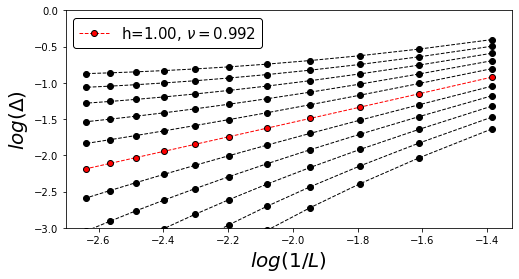

In [4]:
%%time
# -----------------------------------------------------
#// parameter
# -----------------------------------------------------
Llist = np.arange(4,15)
J = 1
hlist = np.linspace(0.8,1.2,11)

# -----------------------------------------------------
#// Calculate
# -----------------------------------------------------
Gaplist = np.zeros([Llist.size,hlist.size])
for i,L in enumerate(Llist):
    for j,h in enumerate(hlist):
        H = -J*Hxx_sparse(L)-h*Hz_sparse(L)
        E = eigsh(H,k=2,which='SA')[0]
        Gaplist[i][j] = E[1]-E[0]

# -----------------------------------------------------
#// Curve fitting
# -----------------------------------------------------
def func(x, a, b):
    return a+b*x
popt, pcov = curve_fit(func, np.log(1/Llist), np.log(Gaplist.T[5]))

# -----------------------------------------------------
#// Plot
# -----------------------------------------------------
plt.figure(figsize=(8,4))
#//----------------------------------
for i in range(hlist.size):
    x, y = np.log(1/Llist), np.log(Gaplist.T[i])
    if i!=5:
        plt.plot(x, y, linewidth=1, marker='o', color='k', linestyle='--', 
                markeredgecolor='k')
    else:
        plt.plot(x, np.log(Gaplist.T[i]), linewidth=1, marker='o', color='r', linestyle='--',
                markeredgecolor='k', label=r'h=%.2f, $\nu=%.3f$'%(hlist[i], 1/popt[1]))
plt.ylim(-3,0)
plt.xlabel('$log(1/L)$', fontsize=20)
plt.ylabel('$log(\Delta)$', fontsize=20)
plt.legend(fontsize=15, loc='best', framealpha=1, edgecolor='k')


## Entropy 

Wall time: 4.39 s


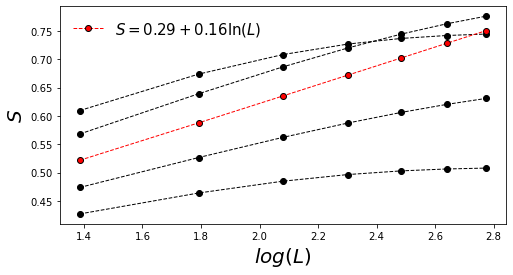

In [116]:
%%time
# -----------------------------------------------------
#// parameter
# -----------------------------------------------------
Llist = np.array([4,6,8,10,12,14,16])
J = 1
hlist = np.linspace(0.8,1.2,5)

# -----------------------------------------------------
#// Calculate
# -----------------------------------------------------
Slist = np.zeros([Llist.size, hlist.size])
for i,L in enumerate(Llist):
    for j,h in enumerate(hlist):
        H = -J*Hxx_sparse(L)-h*Hz_sparse(L)
        w,v = eigsh(H,k=1,which='SA')
        GS = v[:,0].reshape(2**(L//2),2**(L//2))
        u, s, vh = np.linalg.svd(GS)
        Slist[i][j] = -np.sum(s**2*np.log(s**2))
        
# -----------------------------------------------------
#// Curve fitting
# -----------------------------------------------------
def func(x, a, b):
    return a+b*x
popt, pcov = curve_fit(func, np.log(Llist), Slist.T[2])

# -----------------------------------------------------        
#// Plot
# -----------------------------------------------------
plt.figure(figsize=(8,4))
for j,h in enumerate(hlist):
    if j!=2:
        plt.plot(np.log(Llist), Slist.T[j], linewidth=1, marker='o', 
                markeredgecolor='k', color='k', linestyle='--')
    else:
        plt.plot(np.log(Llist), Slist.T[j], linewidth=1, marker='o', 
                markeredgecolor='k', color='r', linestyle='--', label='$S = %.2f + %.2f\ln(L)$'%tuple(popt))
plt.xlabel('$log(L)$', fontsize=20)
plt.ylabel('$S$', fontsize=20)
plt.legend(fontsize=15, loc='best', framealpha=1, edgecolor='w')

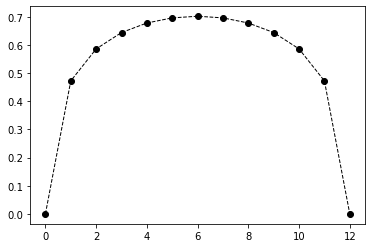

In [132]:
Llist = np.array(4,6,8,10)
J = 1
h = 1

H = -J*Hxx_sparse(L)-h*Hz_sparse(L)
w,v = eigsh(H,k=1,which='SA')

Slist = np.zeros(L+1)

for i in range(1,L):
    GS = v[:,0].reshape(2**(i),2**(L-i))
    u, s, vh = np.linalg.svd(GS)
    Slist[i] = -np.sum(s**2*np.log(s**2))
    
plt.plot(Slist, linewidth=1, marker='o', 
         markeredgecolor='k', color='k', linestyle='--')

## Energy dispersion

(-3.441592653589793, 3.441592653589793)

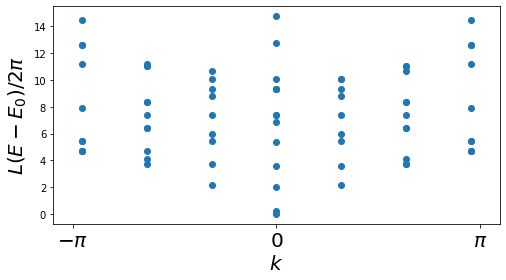

In [15]:
# -----------------------------------------------------
#// parameter
# -----------------------------------------------------
L = 6
J = 1
h = 1

# -----------------------------------------------------
#// Compute E
# -----------------------------------------------------
H = -J*Hxx(L)-h*Hz(L)
w, v = np.linalg.eigh(H)
#// Construct Translational matrix by using eigenstate of H
T = np.zeros([2**L, 2**L])
for j in range(2**L):
    i = j//2 + j%2*2**(L-1) 
    T[i][j] = 1
T_ = v.T @ T @ v

# -----------------------------------------------------
#// Find corresponding k
# -----------------------------------------------------
#// Re-diagnalize the eigenspaces for H and T
tol = 1e-13
T_eigvals, idx = [], []
for i in range(2**L):
    #// check if T_[i][i] is diagonal or not
    if np.sum(abs(T_[i])>tol)+np.sum(abs(T_[:,i])>tol)-int(abs(T_[i][i])>tol)*2 == 0:  
        if len(idx) == 0:
            T_eigvals.append(T_[i][i])
        else:
            w_ = np.linalg.eigvals(T_[idx][:,idx])
            T_eigvals+=list(w_)
            T_eigvals.append(T_[i][i])
            idx = []          
    #// collect index if it has no-zero off-diagonal elements
    else:
        idx.append(i)
T_eigvals = np.array(T_eigvals)
#//----------------------------------
#// find k and n
k = np.log(T_eigvals).imag
n = k*L/2/np.pi

# -----------------------------------------------------
#// Plot
# -----------------------------------------------------
plt.figure(figsize=(8,4))
#//----------------------------------
plt.plot(n, (w-w[0])*L/2/np.pi, linestyle='', marker='o', color='tab:blue')
plt.plot(n-L, (w-w[0])*L/2/np.pi, linestyle='', marker='o', color='tab:blue')
plt.plot(n+L, (w-w[0])*L/2/np.pi, linestyle='', marker='o', color='tab:blue')
plt.xlabel(r'$k$', fontsize=20)
plt.ylabel(r'$L(E-E_0)/2\pi$', fontsize=20)
plt.xticks([-np.pi,0,np.pi], [r'$-\pi$', r'$0$', r'$\pi$'], fontsize=20)
plt.xlim(-np.pi-0.3, np.pi+0.3)

# Ising quantum chain in an imaginary field

$$
H = -\frac{1}{2}\sum_{j}^{L}(\sigma^z_{j}+\lambda\sigma^x_{j}\sigma^x_{j+1}+ih\sigma^{x}_{j})
$$

## Determine critical point $h_c$

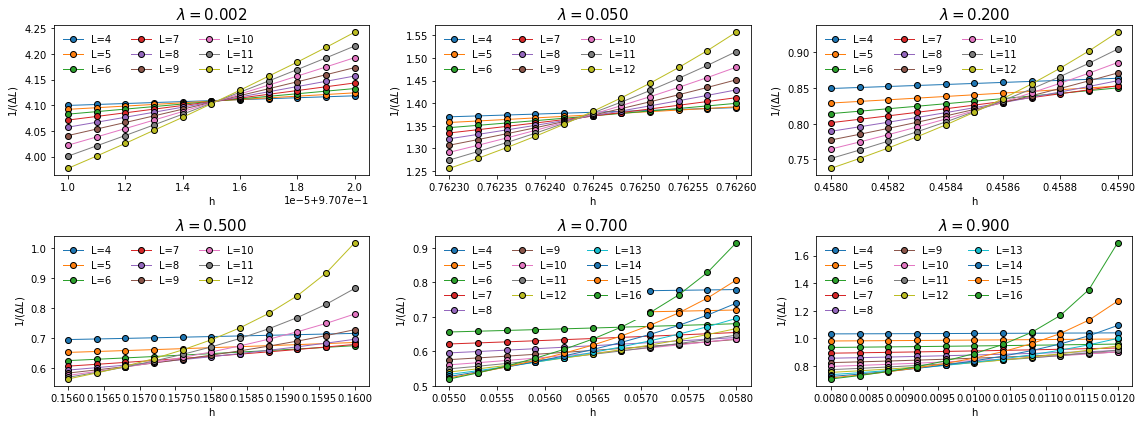

In [6]:
# -----------------------------------------------------
#// parameter
# -----------------------------------------------------
lamblist = [0.002, 0.050, 0.200, 0.500, 0.700, 0.900]

# -----------------------------------------------------
#// Plot
# -----------------------------------------------------
plt.figure(figsize=(16,6))
for s, lamb in enumerate(lamblist):
    #// Read Data
    Llist = np.load('1D-TFIM_report/PlotInverseGap/lamb_%.3f_Llist.npy'%lamb)
    hlist = np.load('1D-TFIM_report/PlotInverseGap/lamb_%.3f_hlist.npy'%lamb)
    Gaplist = np.load('1D-TFIM_report/PlotInverseGap/lamb_%.3f_Gaplist.npy'%lamb)
    plt.subplot(2,3,s+1)
    #// Plot inverse gap v.s. h
    for i in range(Llist.size):
        plt.plot(hlist, 1/Gaplist[i]/Llist[i], linewidth=1, marker='o', 
                markeredgecolor='k', label='L=%d'%Llist[i])
    plt.title('$\lambda=%.3f$'%lamb, fontsize=15)
    plt.xlabel('h', fontsize=10)
    plt.ylabel('$1/(\Delta L)$', fontsize=10)
    plt.legend(ncol=3, framealpha=1, edgecolor='w')
plt.tight_layout()

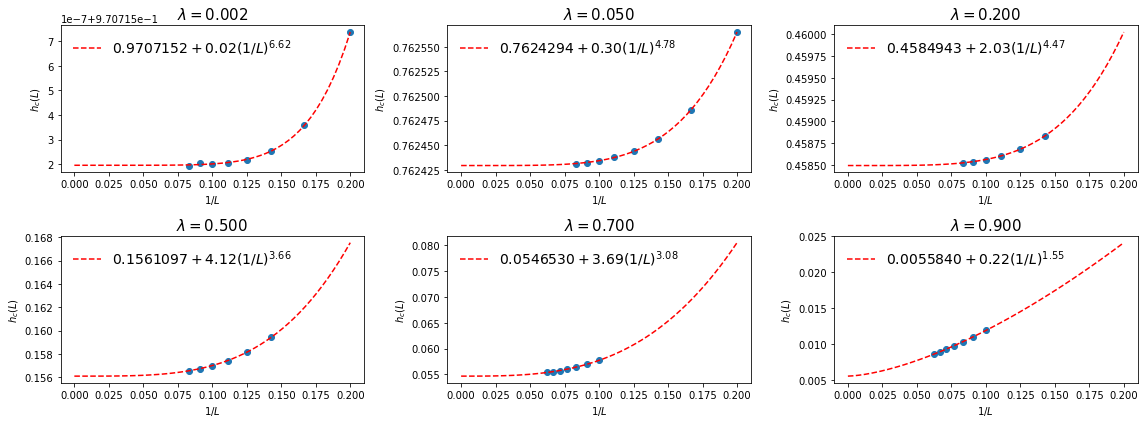

In [7]:
def func(x, a, b, c):
    return a+b*x**c

# -----------------------------------------------------
#// parameter
# -----------------------------------------------------
lamblist = [0.002, 0.050,  0.200, 0.500, 0.700, 0.900]

# -----------------------------------------------------
#// Plot
# -----------------------------------------------------
plt.figure(figsize=(16,6))
hclist = []
for s in range(len(lamblist)):
    #// Read data
    lamb = lamblist[s]
    Llist = np.load('1D-TFIM_report/PlotInverseGap/lamb_%.3f_Llist.npy'%lamb)
    hlist = np.load('1D-TFIM_report/PlotInverseGap/lamb_%.3f_hlist.npy'%lamb)
    Gaplist = np.load('1D-TFIM_report/PlotInverseGap/lamb_%.3f_Gaplist.npy'%lamb)
    #// Determine hc(L)
    hcLlist = []
    for i in range(Llist.size-1):
        y1 = 1/Gaplist[i]/Llist[i]
        y2 = 1/Gaplist[i+1]/Llist[i+1]
        hc = find_crossing(hlist, y1, y2)
        if hc == False: #// no crossing point
            continue
        else:
            hcLlist.append(hc)      
    #// Curve fit
    l = len(hcLlist)
    popt, pcov = curve_fit(func, 1/Llist[-l:], hcLlist)
    hclist.append(popt[0]) #// collect fitting hc
    #// Plot
    plt.subplot(2,3,s+1)
    plt.scatter(1/Llist[-l:], hcLlist)
    x = np.linspace(0, 0.2)
    plt.plot(x, func(x, popt[0], popt[1], popt[2]), 
             linestyle='--', color='r', 
             label='$%.7f + %.2f(1/L)^{%.2f}$'%tuple(popt))
    plt.title('$\lambda=%.3f$'%lamb, fontsize=15)
    plt.xlabel(r'$1/L$', fontsize=10)
    plt.ylabel(r'$h_c(L)$', fontsize=10)
    plt.legend(fontsize=14, framealpha=1, edgecolor='w')
plt.tight_layout()

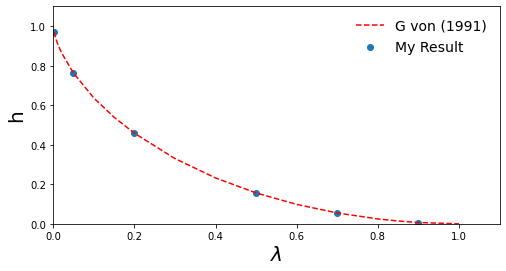

In [8]:
# -----------------------------------------------------
#// parameter
# -----------------------------------------------------
lamblist_ = [0.002, 0.005, 0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 
     0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.85, 0.90, 1.00]
hlist_ = [0.9707, 0.9464, 0.9154, 0.8674, 0.7624, 0.6366, 0.5392, 0.4585,
     0.3300, 0.2320, 0.1562, 0.0981, 0.0548, 0.0247, 0.0141, 0.0065, 0.0000]

# -----------------------------------------------------
#// Plot
# -----------------------------------------------------
plt.figure(figsize=(8,4))
plt.scatter(lamblist, hclist, color='tab:blue', label='My Result')
plt.plot(lamblist_, hlist_, color='r', linestyle='--', label='G von (1991)')
plt.xlabel(r'$\lambda$', fontsize=20)
plt.ylabel(r'h', fontsize=20)
plt.xlim(0.0,1.1)
plt.ylim(0.0,1.1)
plt.legend(fontsize=14, framealpha=1, edgecolor='w')

## Energy dispersion

(0.0, 4.0)

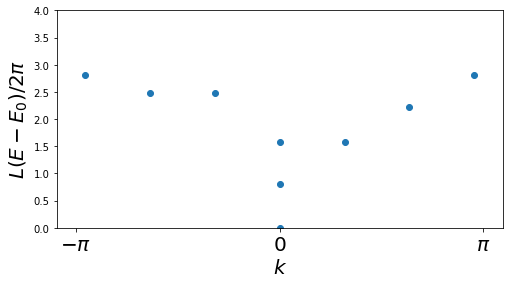

In [9]:
# -----------------------------------------------------
#// parameter
# -----------------------------------------------------
L = 6
lamb = 0.5
h = 0.1

# -----------------------------------------------------
#// Compute E
# -----------------------------------------------------
H = -lamb*Hxx_sparse(L)-Hz_sparse(L)-1j*h*Hx_sparse(L)
w, v = eigs(H,k=8,which='SR')
idx = np.argsort(w.real)
w, v = w[idx].real, v[:,idx]
#// Construct Translational matrix by using eigenstate of H
T = np.zeros([2**L, 2**L])
for j in range(2**L):
    i = j//2 + j%2*2**(L-1) 
    T[i][j] = 1
T_ = np.conjugate(v).T @ T @ v

# -----------------------------------------------------
#// Find corresponding k
# -----------------------------------------------------
#// Re-diagnalize the eigenspaces for H and T
tol = 1e-13
T_eigvals, idx = [], []
for i in range(len(T_)):
    #// check if T_[i][i] is diagonal or not
    if np.sum(abs(T_[i])>tol)-int(abs(T_[i][i])>tol) == 0:  
        if len(idx) == 0:
            T_eigvals.append(T_[i][i])
        else:
            w_ = np.linalg.eigvals(T_[idx][:,idx])
            T_eigvals+=list(w_)
            T_eigvals.append(T_[i][i])
            idx = []          
    #// collect index if it has no-zero off-diagonal elements
    else:
        idx.append(i)
T_eigvals = np.array(T_eigvals)
#//----------------------------------
#// find k and n
k = np.log(T_eigvals).imag
n = k*L/2/np.pi

# -----------------------------------------------------
#// Plot
# -----------------------------------------------------
plt.figure(figsize=(8,4))
#//----------------------------------
plt.plot(n, (w-w[0])*L/2/np.pi, linestyle='', marker='o', color='tab:blue')
plt.plot(n-L, (w-w[0])*L/2/np.pi, linestyle='', marker='o', color='tab:blue')
plt.plot(n+L, (w-w[0])*L/2/np.pi, linestyle='', marker='o', color='tab:blue')
plt.xlabel(r'$k$', fontsize=20)
plt.ylabel(r'$L(E-E_0)/2\pi$', fontsize=20)
plt.xticks([-np.pi,0,np.pi], [r'$-\pi$', r'$0$', r'$\pi$'], fontsize=20)
plt.xlim(-np.pi-0.3, np.pi+0.3)
plt.ylim(0,4)

(-3.441592653589793, 3.441592653589793)

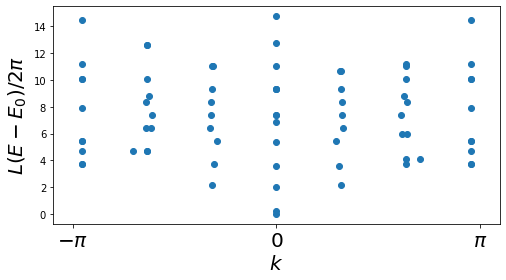

In [10]:
# -----------------------------------------------------
#// parameter
# -----------------------------------------------------
L = 6
lamb = 1
h = 0

# -----------------------------------------------------
#// Compute E
# -----------------------------------------------------
H = -lamb*Hxx(L)-Hz(L)-1j*h*Hx(L)
w, v = np.linalg.eig(H)
idx = np.argsort(w.real)
w, v = w[idx].real, v[:,idx]
#// Construct Translational matrix by using eigenstate of H
T = np.zeros([2**L, 2**L])
for j in range(2**L):
    i = j//2 + j%2*2**(L-1) 
    T[i][j] = 1
T_ = np.conjugate(v).T @ T @ v

# -----------------------------------------------------
#// Find corresponding k
# -----------------------------------------------------
#// Re-diagnalize the eigenspaces for H and T
tol = 1e-13
T_eigvals, idx = [], []
for i in range(len(T_)):
    #// check if T_[i][i] is diagonal or not
    if np.sum(abs(T_[i])>tol)-int(abs(T_[i][i])>tol) == 0:  
        if len(idx) == 0:
            T_eigvals.append(T_[i][i])
        else:
            w_ = np.linalg.eigvals(T_[idx][:,idx])
            T_eigvals+=list(w_)
            T_eigvals.append(T_[i][i])
            idx = []          
    #// collect index if it has no-zero off-diagonal elements
    else:
        idx.append(i)
T_eigvals = np.array(T_eigvals)
#//----------------------------------
#// find k and n
k = np.log(T_eigvals).imag
n = k*L/2/np.pi

# -----------------------------------------------------
#// Plot
# -----------------------------------------------------
plt.figure(figsize=(8,4))
#//----------------------------------
plt.plot(n, (w-w[0])*L/2/np.pi, linestyle='', marker='o', color='tab:blue')
plt.plot(n-L, (w-w[0])*L/2/np.pi, linestyle='', marker='o', color='tab:blue')
plt.plot(n+L, (w-w[0])*L/2/np.pi, linestyle='', marker='o', color='tab:blue')
plt.xlabel(r'$k$', fontsize=20)
plt.ylabel(r'$L(E-E_0)/2\pi$', fontsize=20)
plt.xticks([-np.pi,0,np.pi], [r'$-\pi$', r'$0$', r'$\pi$'], fontsize=20)
plt.xlim(-np.pi-0.3, np.pi+0.3)
